In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-2msv41dv
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-2msv41dv
  Resolved https://github.com/jlopezalo/pyafmreader.git to commit 455c83796458190d25d9ff9b6a4ad8b3e40680b4
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-a3u_gw94/fasterzip_58606e1baac944e99976760ef4292cce
  Running command git clone --filter=blob:none --quiet https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-a3u_gw

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-eqazkfh7
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-eqazkfh7
  Resolved https://github.com/jlopezalo/pyafmrheo.git to commit 979516082978cd81d223da279552182fc9c84903
  Preparing metadata (setup.py) ... done
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=31310 sha256=220257d46d054ed5bd05b874320bbeaa48351b9185e15bf099a1c2ff07cb93ad
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-e3kpji7i/wheels/45/a3/5e/2d19803e3cbf5fe45f904090127b31ec30fc304c6b6e5e0f70
Successfully built pya

In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Datasets/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 30 * 1e-9 # meters
# Poisson ratio
poisson_ratio = 0.5
# Max non contact region
maxnoncontact = 2.5 * 1e-6
# Window to find cp
windowforCP = 70 * 1e-9
# Smooth window
smooth_w = 1
# t0 scaling factor
t0_scaling = 1
# Viscous drag for PFQNM
vdrag = 0.77*1e-6
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = loadfile(file_path)

In [6]:
filemetadata = file.filemetadata
print(filemetadata['file_type'])

.jpk-force-map


In [7]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [8]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

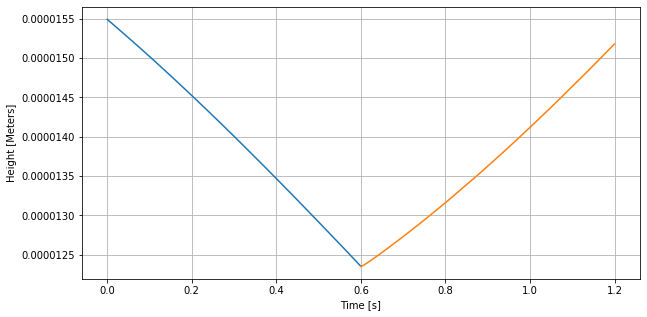

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

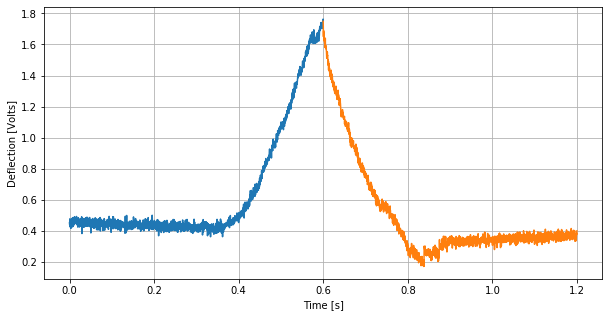

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

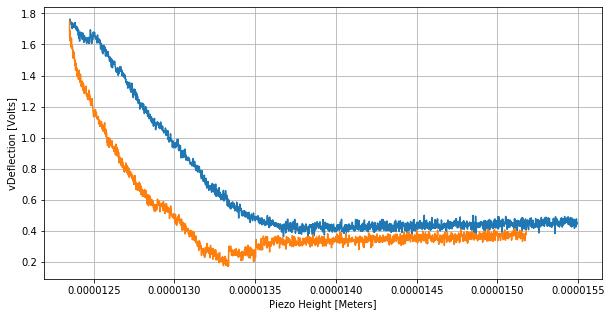

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
first_ext_seg.preprocess_segment(deflection_sensitivity, height_channel)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

In [13]:
# Shift height
xzero = last_ret_seg.zheight[-1] # Maximum height
first_ext_seg.zheight = xzero - first_ext_seg.zheight
last_ret_seg.zheight = xzero - last_ret_seg.zheight

In [14]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [15]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, 350e-9)
print(*poc)

1.505538342280261e-06 -1.8384458131696606e-10


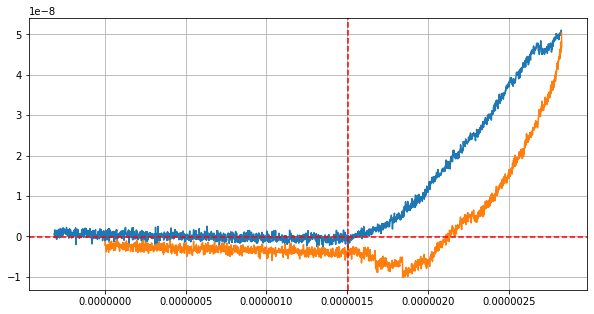

In [16]:
plt.plot(app_height, app_deflection)
plt.plot(ret_height, ret_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

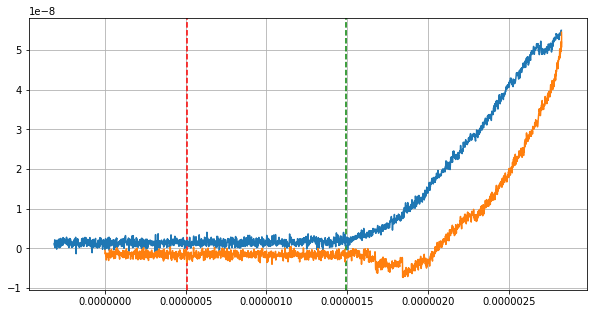

In [17]:
height = np.r_[app_height, ret_height]
deflection = np.r_[app_deflection, ret_deflection]
idx = len(app_height)
corr_defl = correct_tilt(height, deflection, poc[0], 1e-6, 10e-9)
plt.axvline(x=poc[0]-1e-6, color='r', linestyle='--')
plt.axvline(x=poc[0]-10e-9, color='g', linestyle='--')
plt.plot(height[:idx], corr_defl[:idx])
plt.plot(height[idx:], corr_defl[idx:])
plt.grid()
plt.show()

In [18]:
app_deflection = corr_defl[:idx]
ret_deflection = corr_defl[idx:]


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 1.807834384416792e-08

        E0: 1229.8359872154465

        f0: -3.2401356394906017e-13

        slope: None

        # Fit metrics
        MAE: -1.2826546467047066e-17

        MSE: 1.2239302159689443e-22

        RMSE: 1.1063137963385182e-11

        Rsq: 0.994042453618604

        Chisq: 3.1056797863835338e-09

        RedChisq: 1.035226595461178e-09

        


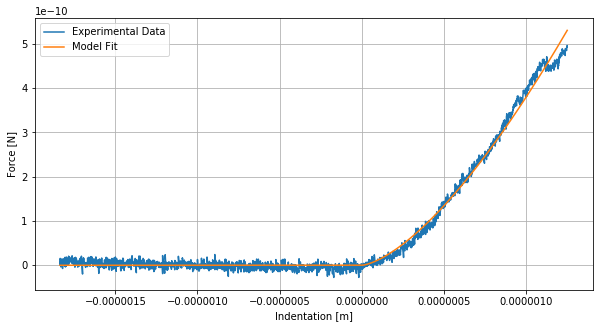

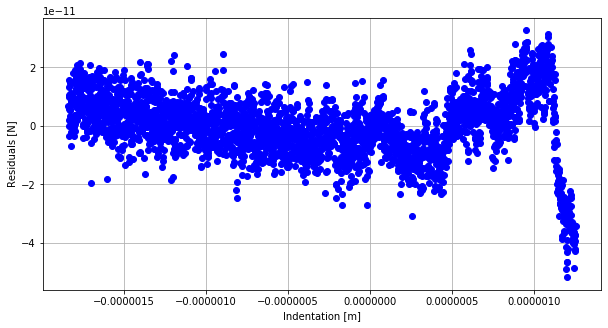

In [19]:
# Hertz fit
poc[1] = 0
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [20]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [21]:
idx_tc = (np.abs(app_indentation - 0)).argmin()
t0 = app_time[-1]
indentation = np.r_[app_indentation, ret_indentation]
time = np.r_[app_time, ret_time + t0]
force = np.r_[app_force, ret_force]
fit_mask = indentation > (-1 * maxnoncontact)
tc = time[idx_tc]
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0] - tc_fit
tc_fit = 0.0
tm = time_fit[np.argmax(force_fit)]

In [22]:
v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']

In [23]:
downfactor= len(time_fit) // 300
print(f'Downfactor --> {downfactor}')
print(f'tm --> {tm}')

Downfactor --> 20
tm --> 0.23440000000000005


In [24]:
idxDown = list(range(0, len(time_fit), downfactor))
idx_tm = np.argmax(force_fit[idxDown])
f0idx = np.where(time_fit==0)[0]
F0_init=force_fit[f0idx]-vdrag*v0t

tc_max = tc_fit+downfactor/(1/(time_fit[1]-time_fit[0]))*10
tc_min = tc_fit-downfactor/(1/(time_fit[1]-time_fit[0]))*10
f0_max = F0_init+100e-12
f0_min = F0_init-100e-12

if hertz_E0 > 10e3:
    betaE_init = 0.05
else:
    betaE_init = 0.25

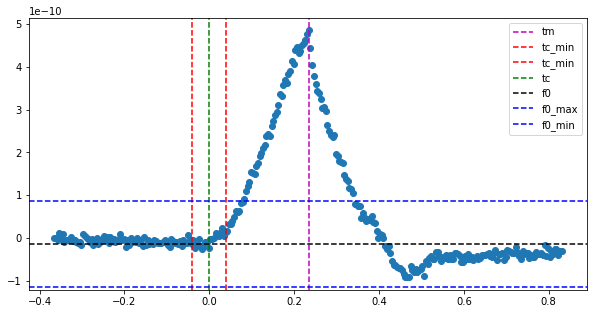

In [25]:
plt.plot(time_fit[idxDown], force_fit[idxDown], 'o')
plt.axvline(x=time_fit[idxDown][idx_tm], color='m', linestyle='--', label='tm')
plt.axvline(x=tc_min, color='r', linestyle='--', label='tc_min')
plt.axvline(x=tc_max, color='r', linestyle='--', label='tc_min')
plt.axvline(x=tc_fit, color='g', linestyle='--', label='tc')
plt.axhline(y=F0_init, color='k', linestyle='--', label='f0')
plt.axhline(y=f0_max, color='b', linestyle='--', label='f0_max')
plt.axhline(y=f0_min, color='b', linestyle='--', label='f0_min')
plt.legend()
plt.show()

In [26]:
model_ting_analytical = TingModel(indenter_shape, tip_parameter, 'analytical')
# E0
model_ting_analytical.E0_init = hertz_E0
model_ting_analytical.E0_min = hertz_E0/1000
model_ting_analytical.E0_max = np.inf

# tc
model_ting_analytical.tc_init = tc_fit
model_ting_analytical.tc_min = tc_min
model_ting_analytical.tc_max = tc_max

# betaE
model_ting_analytical.betaE_init = betaE_init
model_ting_analytical.betaE_min = 0.01
model_ting_analytical.betaE_max = 0.49

# F0
model_ting_analytical.F0_init = F0_init[0]
model_ting_analytical.F0_min = f0_min[0]
model_ting_analytical.F0_max = f0_max[0]

# Do fit
model_ting_analytical.fit(
    time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown],
    t0_scaling, idx_tm, smooth_w, v0t, v0r
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyafmrheo/models/ting.py:265: RuntimeWarning: divide by zero encountered in true_divide
  a = (self.get_residuals(time, F, delta, t0, idx_tm, smooth_w, v0t, v0r)**2/F)


In [27]:
model_ting_numerical = TingModel(indenter_shape, tip_parameter, 'numerical')
# E0
model_ting_numerical.E0_init = hertz_E0
model_ting_numerical.E0_min = hertz_E0/1000
model_ting_numerical.E0_max = np.inf
# tc
model_ting_numerical.tc_init = tc_fit
model_ting_numerical.tc_min = tc_min
model_ting_numerical.tc_max = tc_max
# betaE
model_ting_numerical.betaE_init = betaE_init
model_ting_numerical.betaE_min = 0.01
model_ting_numerical.betaE_max = 0.49
# F0
model_ting_numerical.F0_init = F0_init[0]
model_ting_numerical.F0_min = f0_min[0]
model_ting_numerical.F0_max = f0_max[0]
# Do fit
model_ting_numerical.fit(
    time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown],
    t0_scaling, idx_tm, smooth_w, v0t, v0r
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyafmrheo/models/ting.py:92: RuntimeWarning: invalid value encountered in power
  A = smooth(np.r_[numdiff(delta0[idxCt]**geom_exp), numdiff(delta0[idxCr[0]:]**geom_exp)], smooth_w)


In [28]:
model_ting_analytical.fit_report()
model_ting_numerical.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 150

        Number of free parameters: 4

        E0: 772.0561761018671

        tc: -0.006218690952467354

        betaE: 0.15808850205015693

        F0: -2.7427846669142276e-11

        # Fit metrics
        MAE: -2.784307367791729e-19

        MSE: 4.398096062998585e-22

        RMSE: 2.0971638140590223e-11

        Rsq: 0.9761833853963346

        Chisq: 2.667995630134348e-09

        RedChisq: 6.66998907533587e-10

        

        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 150

        Number of free parameters: 4

        E0: 552.4842335267113

      

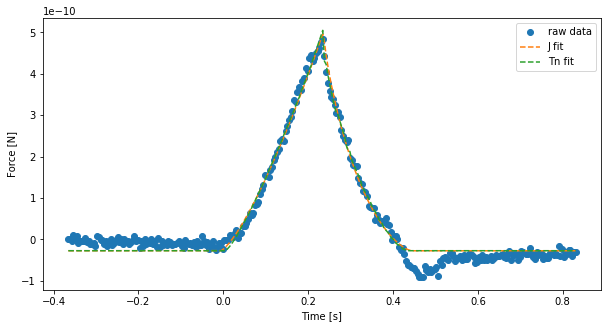

In [29]:
plt.plot(time_fit[idxDown], force_fit[idxDown], 'o', label='raw data')
plt.plot(
    time_fit[idxDown],
    model_ting_analytical.eval(
        time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0_scaling,
        idx_tm, smooth_w, v0t, v0r
    ),
    '--', label='J fit')
plt.plot(
    time_fit[idxDown],
    model_ting_numerical.eval(
        time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0_scaling,
        idx_tm, smooth_w, v0t, v0r
    ),
    '--', label='Tn fit')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.legend()
plt.show()